In [1]:
import os
import sys
import glob
import time
import yaml
import math
import torch as t
import numpy as np
import pandas as pd
from torch import nn
import multiprocessing
from torch.optim import Adam
from astropy import units as u
from astropy import constants as c
from torch.autograd import Variable
from scipy.interpolate import interp1d,interp2d

In [2]:
def Normalizer(spec,shortwave=6500,longwave=7500):
    small=np.argmin(abs(spec[:,0]-shortwave))
    long=np.argmin(abs(spec[:,0]-longwave))
    if small<long:spec[:,1]=spec[:,1]/np.average(spec[small:long,1])
    if small>long:spec[:,1]=spec[:,1]/np.average(spec[long:small,1])
    return spec

In [3]:
def MP(taskid_lst=None, func=None, Nprocs=24):
    def worker(taskid_lst, out_q):
        outdict={}
        for tid in taskid_lst:
            outdict[tid]=func(tid)
        out_q.put(outdict)
    out_q=multiprocessing.Queue()
    chunksize=int(math.ceil(len(taskid_lst)/float(Nprocs)))
    procs=[]
    for i in range(Nprocs):
        p=multiprocessing.Process(target=worker,\
        args=(taskid_lst[chunksize*i:chunksize*(i+1)],out_q))
        procs.append(p)
        p.start()
    resultdict = {}
    for i in range(Nprocs):
        resultdict.update(out_q.get())
    for p in procs:
        p.join()
    return resultdict

In [4]:
sigmaT=c.sigma_T.to('cm^2').value #thompson cross section in cm^2
cli=c.c.to('cm/s').value #speed of light in meter/second
kbc=c.k_B.to('erg/K').value
hli=c.h.to('erg*s').value
mele=c.m_e.to('g').value
stfBlz=c.sigma_sb.to('erg/cm^2/K^4/s').value #stefan boltzmann constant. 
secondsInADay=(1*u.day).to('s').value
v2d07e16=1/2*(hli**2/2/np.pi/kbc/mele)**(3/2)
oneEv=(1*u.eV).to('erg').value

In [5]:
def yamlReaderFunc(yamlName):
    global ModelSaver,linesFile,levelFile,lineWide,veloMin,veloMax,expTime,densDataType,elemDataType,extraEngType
    with open(yamlName,'r') as reader:
        howToRun=yaml.safe_load(reader)
    ModelSaver=howToRun['files']['save_dir']
    linesFile=howToRun['files']['line_file']
    levelFile=howToRun['files']['level_file']
    lineWide=float(howToRun['material']['lines']['line_wide'])
    veloMin=float(howToRun['material']['velocity']['min'])*cli
    veloMax=float(howToRun['material']['velocity']['max'])*cli
    expTime=float(howToRun['material']['density']['exp_time'])*secondsInADay
    
    densDataType=howToRun['material']['density']['data_type']
    global densT0,densFile,densData,veloData,radiData,dSlope,N0,V0,R0
    if densDataType=='file':
        densT0=float(howToRun['material']['density']['t_0'])
        densFile=howToRun['material']['density']['file_name']
        densData=np.loadtxt(densFile)
        veloData=densData[:,0]*100000#Convert from km/s to cm/s. 
        densData=densData[:,1]*(densT0/expTime)**3
        if veloMax>=veloData.max():
            print('Gesa Warning: The upper boundary is too high. ')
            veloMax=veloData.max()
        if veloMin<=veloData.min():
            print('Gesa Error: The lower boundary is too low. ')
            assert False
        radiData=veloData*expTime
    elif densDataType=='power_law':
        dSlope=float(howToRun['material']['density']['slope'])
        N0=float(howToRun['material']['density']['pivot_dens'])
        V0=float(howToRun['material']['density']['pivot_velo'])*cli
        R0=V0*expTime
    
    elemDataType=howToRun['material']['element']['data_type']
    global elemFile,elemData,veloForElem,radiForElem,maxElem,elemSum,elemList
    if elemDataType=='file':
        elemFile=howToRun['material']['element']['file_name']
        elemData=np.loadtxt(elemFile)
        veloForElem=elemData[:,0]*100000
        radiForElem=veloForElem*expTime
        elemData=elemData[:,1:]
        maxElem=elemData.shape[1]
        elemSum=elemData.sum(axis=0)
    elif elemDataType=='one_zone':
        elemList=t.tensor(np.array(howToRun['material']['element']['number_ratio'])).cuda()
        maxElem=len(elemList)
        elemSum=elemList
    
    extraEngType=howToRun['material']['extra_energy']['data_type']
    global extraBounFile,extraSourFile,extraBounVal,extraSourVal,exBounData,exSourData,exEnVelo,exEnRadi,exEnData
    if extraEngType=='file':
        extraBounFile=howToRun['material']['extra_energy']['boun_file']
        extraSourFile=howToRun['material']['extra_energy']['source_file']
        extraBounVal=howToRun['material']['extra_energy']['boun_value']
        extraSourVal=howToRun['material']['extra_energy']['source_value']
        exBounData=np.loadtxt(extraBounFile)
        exSourData=np.loadtxt(extraSourFile)
        exEnVelo=exBounData[:,0]*100000
        exEnRadi=exEnVelo*expTime
        exEnData=exBounData[:,1]*extraBounVal+exSourData[:,1]*extraSourVal
        exEnData[exEnData<0]=0
    elif extraEngType=='zero':
        print('Gesa Info: There is no extra energy other than the boundary condition. ')
    
    global lineLimit,allowShrink,BBBoun,freqMinLog,freqMaxLog,freqSampler,learnRateSchedule,pdeWeight,bo1Weight,bo2Weight,tinyEpochNum,tempMultiRate,zmin,zmax
    lineLimit=float(howToRun['material']['lines']['line_limit'])
    allowShrink=howToRun['material']['lines']['allow_shrink']
    BBBoun=float(howToRun['boundary']['T_inner'])
    freqMinLog=float(howToRun['boundary']['freq_min'])
    freqMaxLog=float(howToRun['boundary']['freq_max'])
    freqSampler=int(howToRun['boundary']['freq_sample'])
    learnRateSchedule=np.array(howToRun['train']['rate_list'])
    pdeWeight=float(howToRun['train']['pde_weight'])
    bo1Weight=float(howToRun['train']['boun1_weight'])
    bo2Weight=float(howToRun['train']['boun2_weight'])
    tinyEpochNum=int(howToRun['train']['tiny_epoch'])
    tempMultiRate=float(howToRun['train']['temp_rate'])
    zmin=expTime*veloMin
    zmax=expTime*veloMax
    
    global l1Norm
    try:l1Norm=howToRun['train']['l1_norm']
    except:print('l1 Norm is not defined')
    return

In [10]:
yamlReaderFunc('N14_Model/runner.yml')
ModelSaver='N14_Model/Saved/'

In [11]:
def BBSpec(freqHz,BBBoun=BBBoun):
    return 2*hli*freqHz**3/cli**2/(np.e**(hli*freqHz/kbc/BBBoun)-1)
freqGrid=np.linspace(freqMinLog,freqMaxLog,num=freqSampler)
freqGrid=10**freqGrid
freqGrid=t.tensor(freqGrid).cuda()
freqWidth=freqGrid*np.log(10)*(freqMaxLog-freqMinLog)/freqSampler
freqGridCpu=freqGrid.cpu()
freqWidthCpu=freqWidth.cpu()
intenMax=BBSpec(freqGrid).max()
tempMax=BBBoun
threeDimStep=200

In [16]:
collBatch=1500
bounBatch=1500
sourSubBa=1500
tempBatch=200
batchNum=200
epochNum=10

In [17]:
class IntenW(nn.Module):
    def __init__(self):
        super(IntenW, self).__init__()
        self.fc1=nn.Linear(2,256)
        self.fc2=nn.Linear(256,256)
        self.fc3=nn.Linear(256,256)
        self.fc4=nn.Linear(256,256)
        self.fc5=nn.Linear(256,256)
        self.fc6=nn.Linear(256,512)
        self.fc7=nn.Linear(512,512)
        self.fc8=nn.Linear(512,512)
        self.fc9=nn.Linear(512,512)
        self.fc10=nn.Linear(512,512)
        self.fc11=nn.Linear(512,2048)
        self.fc12=nn.Linear(2048,2048)
        self.fc13=nn.Linear(2048,2048)
        self.fc14=nn.Linear(2048,freqSampler)
    def forward(self,Xin):
        self.Xin=Xin
        self.out1=self.fc1(Xin)
        self.out2=self.fc2(nn.Tanh()(self.out1))
        self.out3=self.fc3(nn.Tanh()(self.out2))
        self.out4=self.fc4(nn.Tanh()(self.out3))
        self.out5=self.fc5(nn.Tanh()(self.out4))
        self.out6=self.fc6(nn.Tanh()(self.out5))
        self.out7=self.fc7(nn.Tanh()(self.out6))
        self.out8=self.fc8(nn.Tanh()(self.out7))
        self.out9=self.fc9(nn.Tanh()(self.out8))
        self.out10=self.fc10(nn.Tanh()(self.out9))
        self.out11=self.fc11(nn.Tanh()(self.out10))
        self.out12=self.fc12(nn.Tanh()(self.out11))
        self.out13=self.fc13(nn.Tanh()(self.out12))
        self.out14=self.fc14(nn.Tanh()(self.out13))
        return self.out14
    def partialInput(self):
        pout=t.cosh(t.unsqueeze(self.out1,2))**-2*(self.fc1.weight)
        pout=t.cosh(t.unsqueeze(self.out2,2))**-2*(self.fc2.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out3,2))**-2*(self.fc3.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out4,2))**-2*(self.fc4.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out5,2))**-2*(self.fc5.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out6,2))**-2*(self.fc6.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out7,2))**-2*(self.fc7.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out8,2))**-2*(self.fc8.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out9,2))**-2*(self.fc9.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out10,2))**-2*(self.fc10.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out11,2))**-2*(self.fc11.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out12,2))**-2*(self.fc12.weight@pout)
        pout=t.cosh(t.unsqueeze(self.out13,2))**-2*(self.fc13.weight@pout)
        pout=self.fc14.weight@pout
        return pout
IntenWNetFo14=IntenW().double().cuda()
IntenWNetBa14=IntenW().double().cuda()

In [18]:
import matplotlib.pyplot as plt
plt.style.use('default')

In [24]:
leapSpec=np.loadtxt('FormalSolutionOptical.txt')
leapSpec=Normalizer(leapSpec)

Text(3968, 7.7, 'Ca K&H \n3934$\\AA$\n3968$\\AA$')

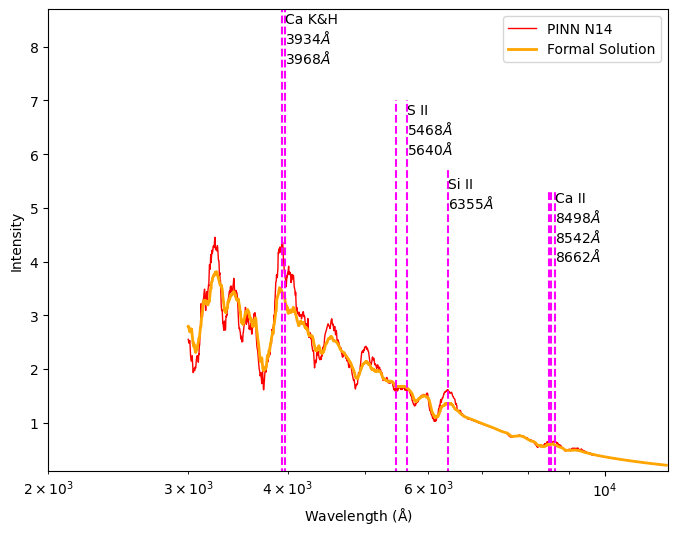

In [34]:
ztp=np.zeros([400,2])
ztp[:,0]=1
phiGrid=np.linspace(0,np.pi/2,num=400)
ztp[:,1]=phiGrid.flatten()
ztp=t.tensor(ztp).cuda()
freqPlot=freqGrid.cpu().detach().numpy()
zRadi=ztp[:,[0]]*(zmax-zmin)+zmin
touchBoun=((zRadi*t.sin(ztp[:,[1]]))<zmin)&(ztp[:,[1]]<np.pi/2)

yamlReaderFunc('N14_Model/runner.yml')
ModelSaver='N14_Model/Saved/'
IntenWNetFo14.load_state_dict(t.load(ModelSaver+'CurrentIntenForward.to'))
IntenWNetBa14.load_state_dict(t.load(ModelSaver+'CurrentIntenBackward.to'))
intenOut=(IntenWNetFo14(ztp)*touchBoun+IntenWNetBa14(ztp)*(1-1*touchBoun))

intePlot=t.mean(intenOut*t.cos(ztp[:,[1]])*t.sin(ztp[:,[1]]),axis=0)*(intenMax)
intePlot=intePlot.cpu().detach().numpy()
intePlot=intePlot*freqPlot**2/cli
inteSpec=np.array([cli/freqPlot*1e8,intePlot]).T
inteSpec=Normalizer(inteSpec)
plt.plot(inteSpec[:,0],inteSpec[:,1],linewidth=1,label='PINN N14',c='red')

plt.plot(leapSpec[:,0],leapSpec[:,1],linewidth=2,label='Formal Solution',c='orange')

plt.gcf().set_size_inches(8,6)
plt.xlim(2000,12000)
plt.ylim(0.1,8.7)
plt.xscale('log')

plt.xlabel(r'Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Intensity')
plt.legend()

plt.plot([8498,8498],[0,5.3],linestyle='--',c='magenta')
plt.plot([8542,8542],[0,5.3],linestyle='--',c='magenta')
plt.plot([8662,8662],[0,5.3],linestyle='--',c='magenta')
plt.text(8662,4,'Ca II \n8498$\AA$\n8542$\AA$\n8662$\AA$')
plt.plot([6355,6355],[0,5.7],linestyle='--',c='magenta')
plt.text(6355,5,'Si II \n6355$\AA$')
plt.plot([5468,5468],[0,7],linestyle='--',c='magenta')
plt.plot([5640,5640],[0,7],linestyle='--',c='magenta')
plt.text(5640,6,'S II \n5468$\AA$\n5640$\AA$')
plt.plot([3934,3934],[0,9.7],linestyle='--',c='magenta')
plt.plot([3968,3968],[0,9.7],linestyle='--',c='magenta')
plt.text(3968,7.7,'Ca K&H \n3934$\AA$\n3968$\AA$')